## 垃圾短信分类处理

### 导入所需工具包&数据

In [1]:
## 数据处理类
import numpy as np 
import pandas as pd 
import warnings

## 数据可视化类
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#from matplotlib.colors import ListedColormap #创建颜色映射表

import wordcloud
from wordcloud import WordCloud

## 自然语言处理类
import re #处理文本字符串，如查找、替换、分割和匹配
import nltk #文本预处理（如分词、词干提取、停用词过滤）、词性标注、命名实体识别、情感分析等各种自然语言处理任务
from nltk.corpus import stopwords #文本预处理
from nltk.tokenize import word_tokenize #分割文本
from nltk.stem.porter import PorterStemmer #词干提取算法
from nltk.stem import WordNetLemmatizer #去标点符号
from collections import Counter

from sklearn.preprocessing import MinMaxScaler,LabelEncoder 
# MinMaxScaler 能将类别型数据转换为数字
# LabelEncoder 进行特征放缩
from sklearn.feature_extraction.text import TfidfVectorizer #将原生文档转化为txt矩阵

## 分析算法类
from sklearn.naive_bayes import MultinomialNB #朴素贝叶斯
from sklearn.ensemble import RandomForestClassifier # 随机森林
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # 支持向量机

## 算法优化类
from sklearn.pipeline import Pipeline #流水线操作
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split 
# GridSearchCV 网格搜索,cross_val_score 交叉验证,train_test_split 数据划分

## 算法评分类
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score

In [2]:
# 加载数据集
data = pd.read_csv("D:/project/Jupyter/csdn/AI_ML/datasets/Lesson4_SMS.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### 数据预处理

In [4]:
# 去除后面三列无意义列
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)

In [5]:
# 重命名前两列 
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 数据探索

Text(0, 0.5, 'Number of Data points')

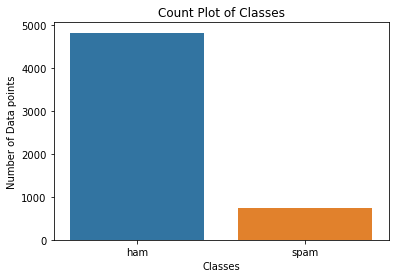

In [6]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(6,4))
fg = sns.countplot(x= data["Target"])
fg.set_title("Count Plot of Classes")
fg.set_xlabel("Classes")
fg.set_ylabel("Number of Data points")

#### 词云搭建

In [7]:
# 数据编码
data['spam'] = data['Target'].map( {'spam': 1, 'ham': 0} ).astype(int)
data.head(5)

,Target,Text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
# 提取出内容列的字符数
data["No_of_Characters"] = data["Text"].apply(len)

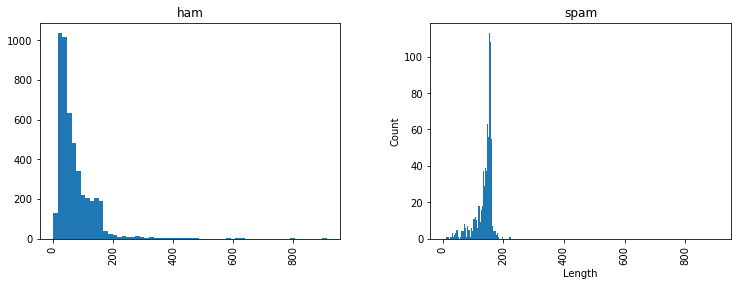

In [9]:
# 分离好坏类的短信，并以句子字符数为横轴绘图
data.hist(column='No_of_Characters', by='Target', bins=60, figsize=(12, 4))
plt.xlim(-40, 950)
plt.xlabel('Length')  # 设置横轴标签
plt.ylabel('Count')   # 设置纵轴标签
plt.show()

In [10]:
data_ham  = data[data['spam'] == 0].copy()
data_spam = data[data['spam'] == 1].copy()

In [11]:
def show_wordcloud(data_spam_or_ham, title):
    Text = ' '.join(data_spam_or_ham['Text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(Text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

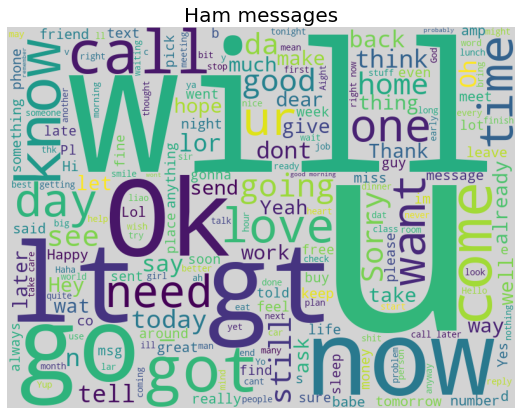

In [12]:
show_wordcloud(data_ham, "Ham messages")

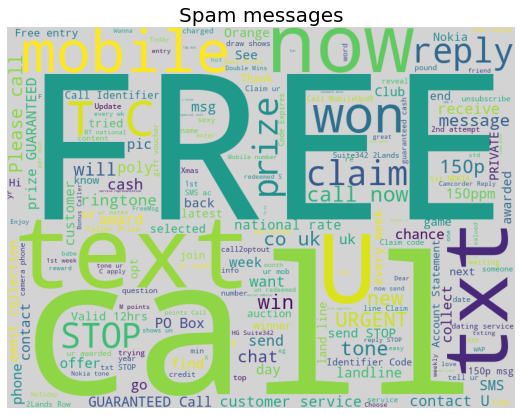

In [13]:
show_wordcloud(data_spam, "Spam messages")

#### 特征工程

为了数据探索的目的，创建功能

No_of_Characters：短信中的字符数；
No_of_Words：短信中的字数；
No_of_sentence：短信中的句子数

In [14]:
#添加列：字符数、单词数和句子数

# data["No_of_Characters"] = data["Text"].apply(len) 
# 字符数前面做词云的时候已经加了，遂注释掉

data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
# 创建新列"No_of_Words"，apply 将一个函数应用到 DataFrame 的每一行（axis=1），定义了一个匿名函数lambda接受行作为输入
# 使用 word_tokenize 函数对该行中的 Text 列进行分词，返回一个单词列表，使用 apply(len) 计算分词结果的长度，即单词的数量

In [15]:
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)
# sent_tokenize 函数返回的是句子列表

In [16]:
data.describe().T # .T 是 DataFrame 的转置操作，将行和列互换

,count,mean,std,min,25%,50%,75%,max
spam,5572.0,0.134063,0.340751,0.0,0.0,0.0,0.0,1.0
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.923546,13.886308,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,2.103553,1.622254,1.0,1.0,2.0,3.0,38.0


<Figure size 864x576 with 0 Axes>

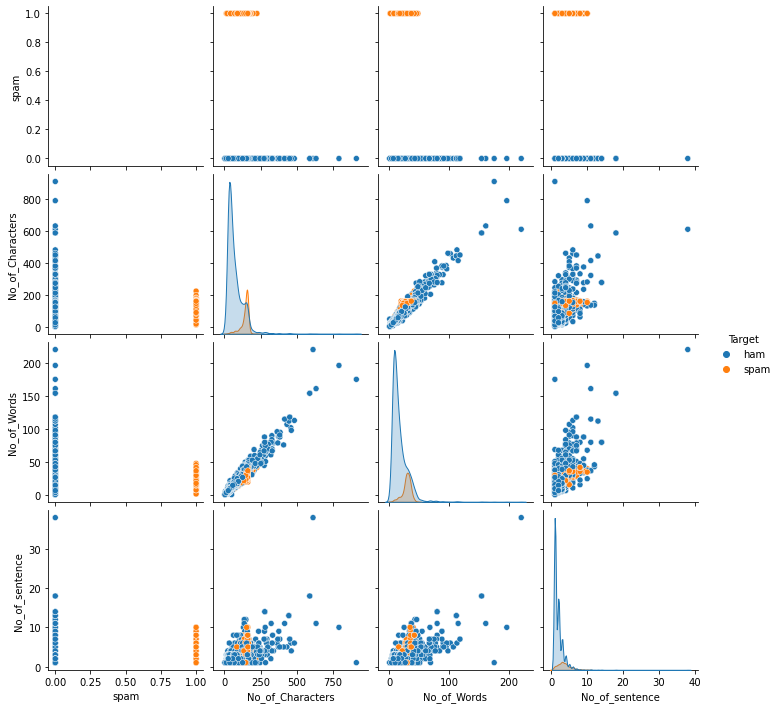

In [17]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target")
plt.show(fg)

从配对图中，可以看到 ham 类中存在一些异常值。因为这三个本质上都表示短信的长度。可以为其中之一设置上限进行测试，所以接下来删除异常值。

#### 异常值检测

In [18]:
#Dropping the outliers. 
data = data[(data["No_of_Characters"]<350)]
data.shape

(5548, 6)

<Figure size 864x576 with 0 Axes>

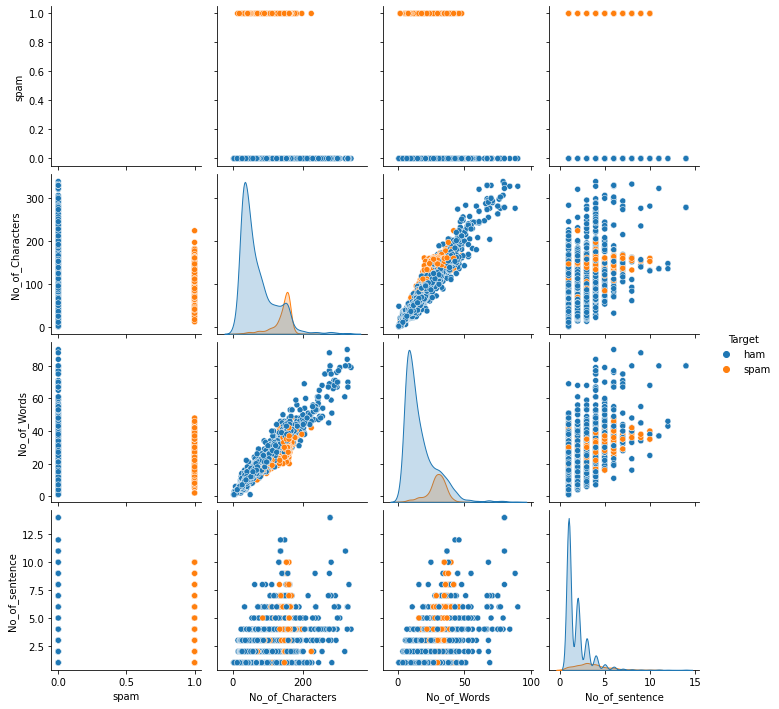

In [19]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target")
plt.show(fg)

### 数据准备

#### 数据清洗

NLP的数据清洗过程至关重要。接下来步骤分为：
1. 仅提取字母字符，删除标点符号和数字。
2. 将所有字符转换为小写。

In [20]:
# 查看数据
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")

 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [21]:
# 编写数据清理函数
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)

# 查看清理后数据
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


#### 文本分解为 token

In [22]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


#### 删除停用词

停用词是经常出现的单词（例如 Few、is、an 等）。这些词在句子结构中有意义，但对 NLP 中的语言处理贡献不大。为了消除处理中的冗余，需要将删除这些内容。标准选用 NLTK 库内的默认停用词组。

In [23]:
# 删除停用词
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


#### 词形还原

词干提取是获取单词词根形式的过程。单词的词干是通过删除单词的前缀或后缀而创建的，词干提取会将其带回词根。
词形还原还将单词转换为其词根形式。然而，不同之处在于，词形还原确保词根属于正在处理的语言。

In [24]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


### 矢量化

NLP 中的 TF-IDF 代表词频——逆文档频率。在 NLP 中，清理后的数据需要转换为数字格式，其中每个单词都由一个矩阵表示。这也称为词嵌入或词向量化。

矢量化的步骤：
1. 创建词形还原文本语料库
2. 将语料库转换为向量形式
3. 对 Target 中的类进行标签编码

In [25]:
#词频 (TF) = (文档中某个词的频率)/(文档中词的总数) 
#逆文档频率 (IDF) = log( (文档总数)/(包含词 t 的文档数) 
#I将使用 TfidfVectorizer() 对预处理后的数据进行矢量化。

#创建文本特征语料库
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [26]:
# 矢量化
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
# 查看特征
X.dtype

dtype('float64')

In [27]:
# 对目标进行标签编码并将其用作 y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

### 模型构建

步骤：
1. 将特征和目标设置为 X 和 y
2. 拆分测试集和训练集
3. 为四个不同的分类器构建模型管道：朴素贝叶斯；随机森林分类器；K邻居分类器；支持向量机
4. 将所有模型拟合到训练数据上
5. 对所有模型的训练集进行交叉验证以确保准确性

In [28]:
y = data["Target"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# 将他们投入不同分类模型
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [30]:
# 交叉验证
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.967552 
RandomForest: 0.975665 
KNeighbours: 0.911450 
SVC: 0.974086 


### 模型评价

在测试集上测试模型：
1. 准确性报告
2. 混淆矩阵

In [31]:
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #评分
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [32]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [33]:
Results.style.background_gradient()

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.974775,0.997521
RandomForest,1.000000,0.823529,0.903226,0.974775,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


混淆矩阵分为四块，分别为
* TN（左上）：非垃圾短信被正确地预测为非垃圾短信。
* FP（右上）：非垃圾短信被错误地预测为垃圾短信（误报）。
* FN（左下）：垃圾短信被错误地预测为非垃圾短信（漏报）。
* TP（右下）：垃圾短信被正确地预测为垃圾短信。

故比较模型时，TN和TP对角线两数值**越大**，FP和FN对角线两数值**越小**，模型性能越好，分类越准确

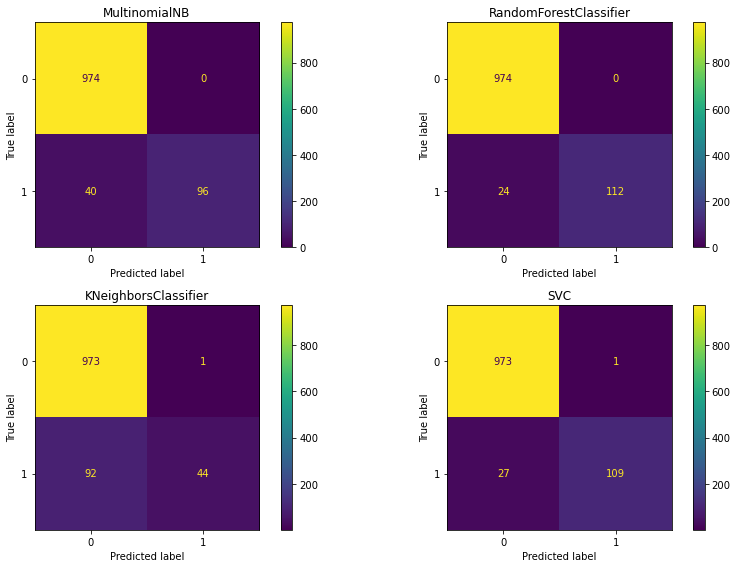

In [34]:
#在同一图中绘制多个分类模型的混淆矩阵，以便比较分类模型的性能
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()